This notebook implements FOOOF model fitting for resting state data. PSD and model fitting settings are based on [Donoghue et al](https://www.nature.com/articles/s41593-020-00744-x). Right now, this is set up to run FOOOF on a subject by subject basis.

In [1]:
import sys
!{sys.executable} -m pip install neurodsp --quiet

You should consider upgrading via the '/Users/christinamaher/Desktop/particle_filter/pf/bin/python -m pip install --upgrade pip' command.


In [3]:
# load required packages 
%matplotlib inline

import os
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from glob import glob

from scipy.signal import periodogram

# MNE & associated code
import mne
from mne.preprocessing import ICA, read_ica
from mne.utils import _time_mask

from autoreject import AutoReject, read_auto_reject
from autoreject.autoreject import _apply_interp

# FOOOF, and custom helper & utility functions
from fooof import FOOOF, FOOOFGroup
from fooof.objs import average_fg
from fooof.plts import plot_spectrum
from fooof.utils import trim_spectrum
from fooof.data import FOOOFSettings
from fooof.analysis import get_band_peak_fm, get_band_peak_fg

# Import spectral power functions
from neurodsp.spectral import compute_spectrum_welch, rotate_powerlaw

# Import utilities for loading and plotting data
from neurodsp.utils import create_times
from neurodsp.utils.download import load_ndsp_data
#from spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

/var/folders/5p/bctklsps5kgb5fk5s1nygs3m0000gn/T/ipykernel_25693/1795832890.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/var/folders/5p/bctklsps5kgb5fk5s1nygs3m0000gn/T/ipykernel_25693/1795832890.py:24: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF, FOOOFGroup


In [4]:
# Initialize some variables

# set up directories
data_dir = '/Users/christinamaher/Documents/GitHub/resting_state_ieeg/preprocess/bp_clean/'
save_dir = '/Users/christinamaher/Documents/GitHub/resting_state_ieeg/fooof/results/'

# get some info about the data/subjects
subject_list = ['MS001','MS003','MS006','MS007','MS008','MS010','MS012','MS014','MS016',
               'MS017','MS018','MS019','MS020','MS022','MS023','MS024','MS025','MS026','MS027','MS028'] # list of subjects
sr = 500 # sampling rate - all subjects were resampled to 500 hz 
num_subjects = len(subject_list) # get number of subjects
print(num_subjects)

20


In [36]:
subject ='MS001' # subject_list[1]
fif_file = glob(f'{data_dir}/{subject}_bp_ref_ieeg.fif')
clean_raw = mne.io.read_raw_fif(fif_file[0], preload=True)
clean_raw

Opening raw data file /Users/christinamaher/Documents/GitHub/resting_state_ieeg/preprocess/bp_clean//MS001_bp_ref_ieeg.fif...
    Range : 0 ... 304687 =      0.000 ...   609.374 secs
Ready.
Reading 0 ... 304687  =      0.000 ...   609.374 secs...


Measurement date,"January 01, 2001 10:19:41 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,128 points
Good channels,61 sEEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [34]:
clean_raw.crop(tmin=10,tmax=430) # take 7 minutes worth of data 
clean_raw

Measurement date,"January 01, 2001 10:19:41 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,128 points
Good channels,61 sEEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [35]:
clean_raw.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas4-lacas5',
 'lacas5-lacas6',
 'lacas6-lacas9',
 'lagit1-lagit2',
 'lagit2-lagit3',
 'lagit3-lagit4',
 'lagit4-lagit5',
 'lagit7-lagit8',
 'lagit8-lagit9',
 'lhplt1-lhplt2',
 'lhplt2-lhplt3',
 'lhplt3-lhplt4',
 'lhplt4-lhplt6',
 'lhplt6-lhplt7',
 'lhplt7-lhplt8',
 'lhplt8-lhplt9',
 'lhplt9-lhplt10',
 'lmcms1-lmcms2',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmcms6-lmcms7',
 'lmolf1-lmolf2',
 'lmolf3-lmolf4',
 'lmolf4-lmolf5',
 'lmolf7-lmolf8',
 'lmolf8-lmolf9',
 'lmolf9-lmolf10',
 'lmtpt1-lmtpt2',
 'lmtpt2-lmtpt3',
 'lmtpt6-lmtpt7',
 'lmtpt7-lmtpt8',
 'racas1-racas2',
 'racas3-racas4',
 'racas4-racas5',
 'racas5-racas7',
 'racas8-racas9',
 'racas9-racas10',
 'ragit1-ragit2',
 'ragit2-ragit3',
 'ragit3-ragit4',
 'rhplt1-rhplt5',
 'rhplt8-rhplt9',
 'rmcms1-rmcms2',
 'rmcms2-rmcms3',
 'rmcms3-rmcms4',
 'rmcms4-rmcms5',
 'rmcms7-rmcms8',
 'rmolf1-rmolf2',
 'rmolf3-rmolf4',
 'rmolf4-rmolf5',
 'rmolf5-rmolf8',
 'rmolf8-rmolf9',
 'rmolf

In [26]:
num_channels = len(clean_raw.ch_names) # get number of channels
freq_master = np.zeros((77,)) # frequency - initialize list to store frequency for each channel
psd_master = np.zeros((num_channels, 77)) # power spectral density - initialize list to store psd for each channel
ch_names = clean_raw.ch_names # get channel names

for channel in range(num_channels):
    # compute power spectral density for each channel using welch method, median average, hann window, 2 second window, 50% overlap 
    freq, psd = compute_spectrum_welch(sig=clean_raw._data[channel,:], fs=sr, window='hann',avg_type='median',nperseg=sr*2,f_range=(2,40),noverlap=(sr*2)/2)
    psd_master[channel,:] = psd 
    if channel == 0: # only need to get frequency once
        freq_master[:,] = freq
    else:
        continue # continue to next channel

Running FOOOFGroup across 83 power spectra.


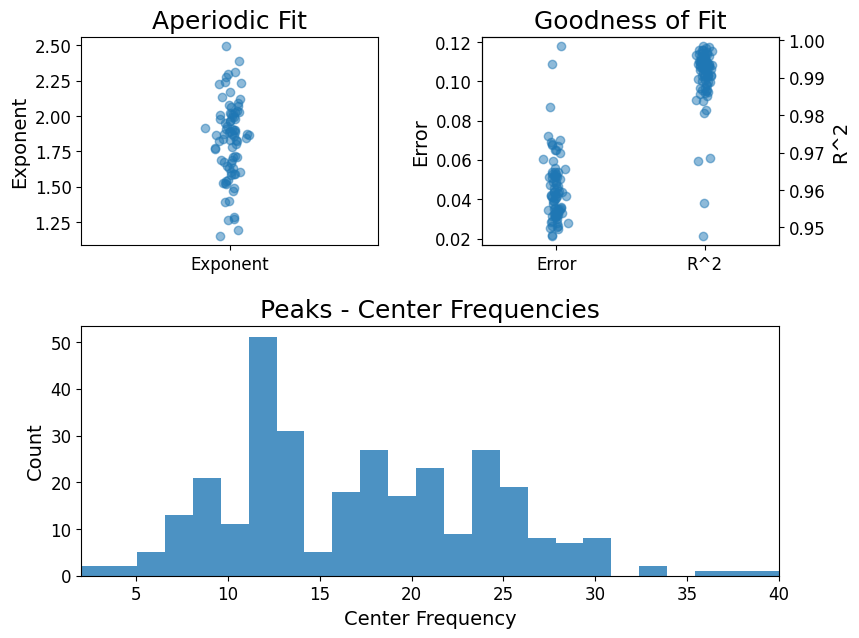

In [27]:
# Run FOOOF on the power spectra for each channel in each subject and store the results
fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_height = 0.1, peak_threshold=2, aperiodic_mode = 'fixed')
fg.fit(freq_master, psd_master, freq_range=[1, 40])

# Plot a summary of the results across the group (i.e., channels in one subject's worth of data)
fg.plot()

# Save out PDF reports of the FOOOFGroup fits, same as with FOOOF
os.chdir(f'/Users/christinamaher/Documents/GitHub/resting_state_ieeg/fooof/results/')
fg.save_report(f'FOOOFGroup_report_{subject}')

In [28]:
# Extract aperiodic parameters
aps = fg.get_params('aperiodic_params')
exps = fg.get_params('aperiodic_params', 'exponent')

# Extract peak parameters
peaks = fg.get_params('peak_params')

# Extract goodness-of-fit metrics
errors = fg.get_params('error')
r2s = fg.get_params('r_squared')

ch_name_list = []

for c in range(len(peaks[:, 3])):
    ch_num_temp = int(peaks[:, 3][c])
    ch_name_temp = ch_names[ch_num_temp]
    ch_name_list.append(ch_name_temp)

# Create a dataframe to store the results
aperiodic_df = pd.DataFrame({
    'ch_name': ch_names,
    'subject': np.repeat(subject, num_channels),
    'aperiodic_exponent': exps,
    'aperiodic_offset': aps[:, 0],
    'error': errors,
    'r^2': r2s
})

periodic_df = pd.DataFrame({
    'ch_name': ch_name_list,
    'subject': np.repeat(subject, len(ch_name_list)),
    'power': peaks[:, 0],
    'center_freq': peaks[:, 1],
    'bandwidth': peaks[:, 2]
})

# for each center_freq in the dataframe, create another column and store whether it falls with the delta, theta, alpha, beta, or gamma band
periodic_df['freq_band'] = pd.cut(periodic_df['center_freq'], [1, 4, 8, 13, 20, 30, 40], labels=['delta', 'theta', 'alpha', 'low_beta', 'high_beta', 'gamma'])

# for each ch_name and sub_id, create another column and store the sub_id and ch_name as a unique identifier (helpful for visualizing/stats)
periodic_df['uniqueID'] = periodic_df['ch_name'] + '_' + periodic_df['subject']
aperiodic_df['uniqueID'] = aperiodic_df['ch_name'] + '_' + aperiodic_df['subject']

In [29]:
# Save DataFrame to CSV
periodic_df.to_csv(f'{save_dir}/{subject}_periodic_df.csv', index=False)
aperiodic_df.to_csv(f'{save_dir}/{subject}_aperiodic_df.csv', index=False)

# Initialize dataframe to store fooof results with YBA labels - didn't do in first pass (3/14/23)
df_YBA = pd.DataFrame()

for subject in subject_list:
    YBA = pd.read_csv(f'YBA_{subject}.csv')
    df_temp = df[df['sub_id'] == subject]
    df_temp['yba_label'] = df_temp['ch_name'].map(YBA.set_index('ch_name')['YBA'])
    df_YBA = df_YBA.append(df_temp)